# Prior and posterior predictive distributions

In [1]:
from cmdstanpy import CmdStanModel
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
import scipy.stats as stats

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prior distribution selection

In [4]:
# since there are 20% reactions on average, we're looking at a distribution with mean=0.2
# the beta distribution has an average equal to a/(a+b), so we can easily find a suitable pair of parameters
# for example:
mean, *_ = stats.beta.stats(a=4, b=16)
mean
# let's use this pair of params

0.2

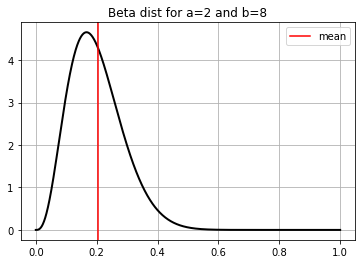

In [24]:
x = np.linspace(0, 1, 1000)
rv = stats.beta(a=4, b=16)
plt.plot(x, rv.pdf(x), 'k-', lw=2)
plt.axvline(x=mean, color='r', label='mean')
plt.title(r'Beta dist for a=2 and b=8')
plt.grid()
plt.legend()
plt.show()

## Modelling prior distribution

In [29]:
%%writefile model_1.stan

generated quantities {
  int<lower=0> N = 50; 
  real<lower=0, upper=1> p = beta_rng(4, 16); 
  int<lower=0, upper=N> y = binomial_rng(N, p);
}


Overwriting model_1.stan


In [30]:
gen_quant = CmdStanModel(stan_file='model_1.stan')

INFO:cmdstanpy:compiling stan file /home/Lab3/model_1.stan to exe file /home/Lab3/model_1
INFO:cmdstanpy:compiled model executable: /home/Lab3/model_1


In [31]:
samples = gen_quant.sample(data={'N': 50}, 
                            fixed_param=True, 
                            iter_sampling=1000, 
                            iter_warmup=0, 
                            chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [32]:
df = samples.draws_pd()
df.head()

,lp__,accept_stat__,N,p,y
0,0.0,0.0,50.0,0.140924,8.0
1,0.0,0.0,50.0,0.111608,8.0
2,0.0,0.0,50.0,0.308695,17.0
3,0.0,0.0,50.0,0.119336,6.0
4,0.0,0.0,50.0,0.053135,5.0


In [33]:
df['ratio'] = df.y / 50
mean = df['ratio'].mean()
print(f"mean from generated samples: [{mean}]")
print(f"difference to the exact value of 0.2: [{abs(mean - 0.2)}]")
print(f"expressed as percentage of 0.2: [{abs(mean - 0.2)/0.2 * 100.0}]")
# as we can see the percentage error quite small

mean from generated samples: [0.20198000000000002]
difference to the exact value of 0.2: [0.0019800000000000095]
expressed as percentage of 0.2: [0.9900000000000048]


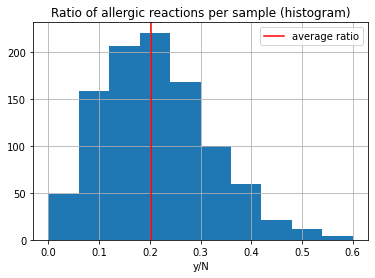

In [35]:
df['ratio'].hist(bins=10)
plt.axvline(x=mean, color ='r', label='average ratio')
plt.xlabel("y/N")
plt.title('Ratio of allergic reactions per sample (histogram)')
plt.legend()
plt.show()
# the average (as well as the general shape of the histogram) seems to be aligned with the prior beta distribution

## Modeling posterior and posterior predictive distribution

In [36]:
%%writefile model_2.stan

data {
  int<lower=0> N;
  int<lower=0, upper=N> y;
}

parameters {
  real<lower=0, upper=1> p;
}

model {
  p ~ beta(4, 12);
  y ~ binomial(N, p);
}

generated quantities {
  int<lower=0, upper=N> y_pred = binomial_rng(N, p);
}

Overwriting model_2.stan


In [37]:
gen_quant = CmdStanModel(stan_file='model_2.stan')

INFO:cmdstanpy:compiling stan file /home/Lab3/model_2.stan to exe file /home/Lab3/model_2
INFO:cmdstanpy:compiled model executable: /home/Lab3/model_2


In [38]:
samples = gen_quant.sample(data={'N': 50, 'y': 7})

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [39]:
df = samples.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,p,y_pred
0,-31.0517,0.858264,0.849406,2.0,3.0,0.0,31.2679,0.249316,11.0
1,-30.5888,0.576805,0.849406,1.0,3.0,0.0,34.1198,0.112725,6.0
2,-30.2490,1.000000,0.849406,1.0,1.0,0.0,30.5522,0.123792,3.0
3,-29.8307,0.993781,0.849406,2.0,3.0,0.0,30.3255,0.147454,10.0
4,-30.3770,0.951157,0.849406,2.0,7.0,0.0,30.3770,0.222683,16.0


In [40]:
ratios = df['y_pred'] / 50
ratios = ratios.to_numpy()

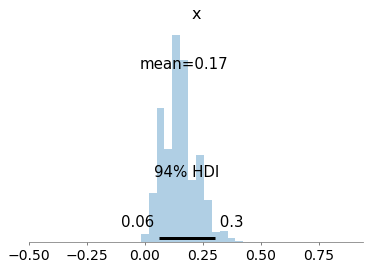

In [41]:
az.plot_posterior(ratios, kind='hist', hdi_prob=0.94, point_estimate='mean')
plt.show()

In [44]:
p = df['p'].to_numpy()

ratio_mean = np.mean(ratios)
ratio_hdi = az.hdi(ratios, hdi_prob=0.94)

p_mean = np.mean(p)
p_hdi = az.hdi(p, hdi_prob=0.94)

print(f"Predicted ratio: [mean:[{ratio_mean}], 94_HDI:{ratio_hdi}]")
print(f"Parameter p: [mean:[{p_mean}], 94_HDI:{p_hdi}]")

p_avg = 0.2
ratio_prob = np.mean(ratios < p_avg)

print(f"Probability that ratio is lower than average: [{ratio_prob}]")

Predicted ratio: [mean:[0.166475], 94_HDI:[[0.06 0.3 ]]]
Parameter p: [mean:[0.165537802625], 94_HDI:[0.0845096 0.25045  ]]
Probability that ratio is lower than average: [0.65875]
